### Import the required libraries

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import pydot

In [372]:
# plt.style.use('dark_background')

## Load the dataset

In [373]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Preprocess the data

### Separate the input features and target variable

In [374]:
X = data.drop('charges', axis=1)
y = data['charges']

### One-hot encode the categorical features

In [375]:
categorical_features = ['sex', 'smoker', 'region']
categorical_transformer = OneHotEncoder()
numerical_features = ['age', 'bmi', 'children']
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

X = preprocessor.fit_transform(X)

### Split the data into training and testing sets

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build the neural network model

In [377]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='sigmoid'),
    Dense(64, activation='tanh'),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])


### Compile the model

In [378]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [379]:
def plot_loss_accuracy(history):
    # Get training loss and accuracy for each epoch
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training loss and validation loss
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    plt.figure(figsize=(8, 6))
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Training Loss and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
   
    mae=history.history['mae']
    val_mae=history.history['val_mae']
    ax[1].plot(mae,label='Training MAE')
    ax[1].plot(val_mae,label='Validation MAE')
    ax[1].set_title('Training MAE and Validation MAE')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].legend()
    plt.show()

### Train the model

In [380]:
history = model.fit(X_train, y_train,epochs=500, verbose=0,validation_data=(X_test,y_test),batch_size=64)

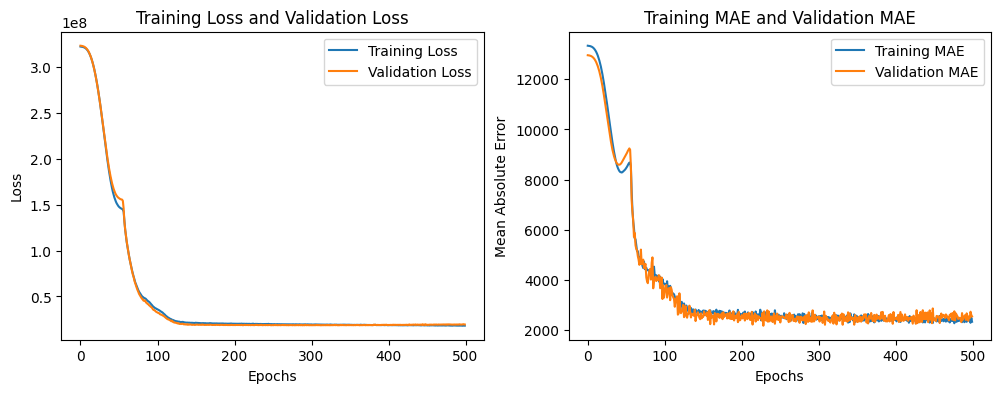

<Figure size 800x600 with 0 Axes>

In [381]:
plot_loss_accuracy(history)

In [382]:
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 1ms/step


### Evaluate the model's performance

In [383]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.2f}, Test MAE: {test_mae:.2f}')

Test loss: 19395006.00, Test MAE: 2528.57


#### R2 Score

In [384]:
r2_score(y_test,y_pred)

0.8750716167529791

#### RMSE

In [385]:
rmse =mean_squared_error(y_test,y_pred,squared=False)
print(rmse)

4403.97241435708


#### Range

In [386]:
min(data['charges']),max(data['charges'])

(1121.8739, 63770.42801)

### Make predictions on new data

In [387]:
new_data = pd.DataFrame({
    'age': [19],
    'sex': ['female'],
    'bmi': [27.9],
    'children': [0],
    'smoker': ['yes'],
    'region': ['southwest'],
    'income': [1200000]
})
new_data_transformed = preprocessor.transform(new_data)
prediction = model.predict(new_data_transformed)[0][0]

if prediction<new_data['income'][0]/12:
    print('Predicted charges:', prediction)
else:
    print('The applicant cannot pay for the insurance')

1/1 [==============================] - 0s 21ms/step
Predicted charges: 16840.23


In [388]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 128)               1536      
                                                                 
 dense_105 (Dense)           (None, 64)                8256      
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dense_107 (Dense)           (None, 16)                528       
                                                                 
 dense_108 (Dense)           (None, 1)                 17        
                                                                 
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [389]:
model.save('./Model/model.h5')

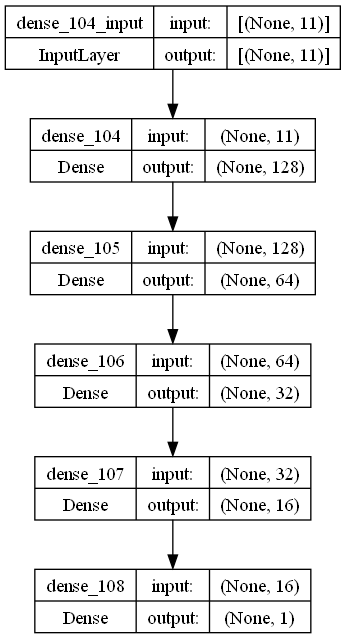

In [390]:
# dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file='neural_network_model.png', show_shapes=True)

In [391]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

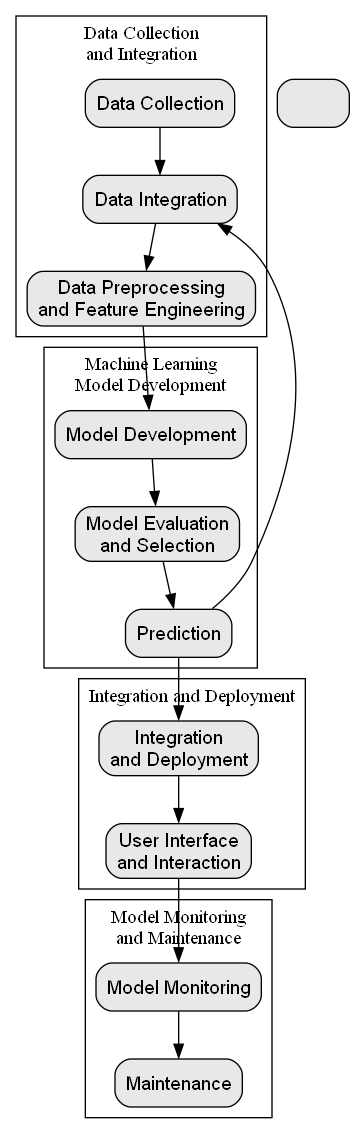

In [392]:
graphs = pydot.graph_from_dot_file('architecture.dot')
graph = graphs[0]
view_pydot(graph)